In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from  nltk import FreqDist

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers

import re
import string

In [4]:
df = pd.read_pickle("../data/processed.pkl")
df

,Publication,Content,Bias,num_bias,processed_content
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left,0,istanbul least people killed least wounded att...
1,CNN,Atlanta (CNN) This season’s College Football P...,Left,0,atlanta season college football playoff center...
2,CNN,(CNN) Revelers on the United States’ west coa...,Left,0,reveler united state west coast cheered advent...
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left,0,west palm beach florida donald trump said satu...
4,CNN,(CNN) Two small planes collided in Texas on S...,Left,0,two small plane collided texas saturday killin...
...,...,...,...,...,...
85360,National Review,I first read Thomas Sowell in college — no ...,Right,2,first read thomas sowell college thanks colleg...
85361,National Review,Whether it’s celebrated according to the Grego...,Right,2,whether celebrated according gregorian julian ...
85362,National Review,Editor’s Note: This piece first appeared in th...,Right,2,editor note piece first appeared april issue n...
85363,National Review,Israel would seem to be in a disastrous positi...,Right,2,israel would seem disastrous position given in...


In [5]:
df.isnull().sum()

Publication          0
Content              0
Bias                 0
num_bias             0
processed_content    0
dtype: int64

In [6]:
# Content of each article
X = df[["processed_content"]]
# Target of biases
y= df["num_bias"]
#set random seed
seed = 42
#holdout set
X_hold, X_test, y_hold, y_test = train_test_split(X, y, test_size=0.10, random_state=seed)
#training set
X_train, X_val, y_train, y_val = train_test_split(X_hold, y_hold, test_size=0.25, random_state=seed)

In [53]:
X_train.head()

,processed_content
60555,tuesday broadcast situation room senator rober...
34511,top health official expressed heightened conce...
43210,dozen incredible kid clarke middle school wrot...
62118,new mexico democrat assigning new bill number ...
39828,sign receive report right inbox ly kjmnnn midd...


In [54]:
X_train.shape

(57620, 1)

In [55]:
y_train.shape

(57620,)

In [56]:
y_train.head()

60555    2
34511    1
43210    1
62118    2
39828    1
Name: num_bias, dtype: int64

In [57]:
X_val.head()

,processed_content
66202,texas bbq restaurant made transgender bathroom...
77557,former nbc news anchor tom brokaw agrees news ...
45472,one week since hillary clintonhillary diane ro...
72123,home state kentucky senate majority leader ral...
1349,typical target specific medium outlet exclude ...


In [58]:
X_val.shape

(19207, 1)

In [59]:
y_val.shape

(19207,)

In [60]:
y_val.head()

66202    2
77557    2
45472    1
72123    2
1349     0
Name: num_bias, dtype: int64

In [61]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57620 entries, 60555 to 32481
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   processed_content  57620 non-null  object
dtypes: object(1)
memory usage: 900.3+ KB


In [62]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19207 entries, 66202 to 40852
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   processed_content  19207 non-null  object
dtypes: object(1)
memory usage: 300.1+ KB


In [145]:
cvec = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=3000)
cvec

CountVectorizer(max_features=3000, ngram_range=(1, 2), stop_words='english')

In [146]:
from itertools import islice
cvec.fit(X_train["processed_content"])
list(islice(cvec.vocabulary_.items(), 20))

[('tuesday', 2790),
 ('broadcast', 323),
 ('situation', 2471),
 ('room', 2308),
 ('senator', 2399),
 ('robert', 2299),
 ('sentence', 2406),
 ('time', 2715),
 ('seriously', 2412),
 ('russia', 2326),
 ('recent', 2165),
 ('election', 844),
 ('role', 2304),
 ('wikileaks', 2941),
 ('played', 1952),
 ('regard', 2194),
 ('sure', 2625),
 ('type', 2803),
 ('message', 1647),
 ('send', 2400)]

In [147]:
tfidf_vectorizer = TfidfVectorizer(max_features=3000, 
                                   ngram_range=(1,2),
                                  max_df =.95, min_df = 6)

tfidf_vectorizer.fit(X_train["processed_content"])
X_train_tfidf_vec = tfidf_vectorizer.transform(X_train["processed_content"])
X_val_tfidf_vec = tfidf_vectorizer.transform(X_val["processed_content"])

In [148]:
X_train_tfidf_vec

<57620x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 10712088 stored elements in Compressed Sparse Row format>

In [149]:
X_train_tfidf_vec_df = pd.DataFrame(X_train_tfidf_vec.toarray(),columns=cvec.get_feature_names(), 
                              index=X_train.index)
X_val_tfidf_vec_df = pd.DataFrame(X_val_tfidf_vec.toarray(), columns=cvec.get_feature_names(), 
                              index=X_val.index)

X_train_tfidf_vec_df.shape

(57620, 3000)

In [159]:
X_train_tfidf_vec_df.head()

,abc,ability,able,abortion,abroad,absolutely,abuse,academic,academy,accept,...,york time,young,young people,younger,youth,youtube,zero,zika,zone,zuckerberg
60555,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
34511,0.0,0.0,0.0,0.0,0.0,0.040944,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.659306,0.0,0.0
43210,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
62118,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
39828,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [158]:
X_val_tfidf_vec_df.head()

,abc,ability,able,abortion,abroad,absolutely,abuse,academic,academy,accept,...,york time,young,young people,younger,youth,youtube,zero,zika,zone,zuckerberg
66202,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
77557,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.042649,0.0,0.0,0.0,0.0,0.0,0.0
45472,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
72123,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1349,0.0,0.0,0.032112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
X_train_tfidf_vec_df.to_pickle("../data/X_train_tfidf_vec_df.pkl")


In [185]:
X_val_tfidf_vec_df.to_pickle("../data/X_val_tfidf_vec_df.pkl")

In [152]:
weights = np.asarray(X_train_tfidf_vec_df.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
2758,treatment,0.062134
2313,round,0.048158
2531,sport,0.026101
2007,presence,0.026009
1906,pennsylvania,0.025653
2965,worried,0.025445
474,clinton campaign,0.025403
1815,okay,0.022801
1747,negative,0.022628
2980,year,0.022158


## Modeless Predictions

In [153]:
y_train.value_counts(normalize= True)

 1    0.348889
-1    0.328046
 0    0.323065
Name: num_bias, dtype: float64

In [2]:
X_train_tfidf_vec_df= pd.read_pickle("../data/X_train_tfidf_vec_df.pkl")

In [3]:
X_val_tfidf_vec_df= pd.read_pickle("../data/X_val_tfidf_vec_df.pkl")

## Baseline Model

In [154]:
models = [
    LogisticRegression(random_state=seed),
    MultinomialNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=seed),
    SGDClassifier(loss= "hinge", penalty= "l2", alpha=.01)]

In [155]:
for model in models:
    model_name = model.__class__.__name__
    scores= cross_validate(model, X_train_tfidf_vec_df, y_train, 
                                scoring=['accuracy', "precision_micro", "recall_micro", "f1_micro"],
                                return_train_score= True)
    model_scores = pd.DataFrame.from_dict(scores)
    print(f"{model_name}'s average score")
    print(model_scores.mean(axis=0))
    print("*"*40)

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

LogisticRegression's average score
fit_time                 51.739990
score_time                0.210016
test_accuracy             0.919715
train_accuracy            0.938502
test_precision_micro      0.919715
train_precision_micro     0.938502
test_recall_micro         0.919715
train_recall_micro        0.938502
test_f1_micro             0.919715
train_f1_micro            0.938502
dtype: float64
******************************
MultinomialNB's average score
fit_time                 1.163888
score_time               0.184413
test_accuracy            0.792329
train_accuracy           0.796763
test_precision_micro     0.792329
train_precision_micro    0.796763
test_recall_micro        0.792329
train_recall_micro       0.796763
test_f1_micro            0.792329
train_f1_micro           0.796763
dtype: float64
******************************
DecisionTreeClassifier's average score
fit_time                 156.447419
score_time                 0.211613
test_accuracy              0.846546
train_

### Logitsic Regression

In [160]:
seed = 42

In [162]:
lr = LogisticRegression(random_state=seed, multi_class="auto")
lr.fit(X_train_tfidf_vec_df, y_train)
print(lr.score(X_train_tfidf_vec_df, y_train))
print(lr.score(X_val_tfidf_vec_df, y_val))

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9382158972578966
0.9233092101837872


In [163]:
lr_tuned = Pipeline(steps=[
    ('clf', LogisticRegression(random_state=seed)),
])
lr_tuned

Pipeline(steps=[('clf', LogisticRegression(random_state=42))])

In [164]:
param_grid = {
    'clf__penalty': ["l2"],
    'clf__max_iter': [1000],
    'clf__C': [1],
    'clf__solver': ['newton-cg'],
}

In [165]:
grid = GridSearchCV(lr_tuned, param_grid, return_train_score=True)

In [166]:
output = grid.fit(X_train_tfidf_vec_df, y_train)

In [167]:
output.best_estimator_

Pipeline(steps=[('clf',
                 LogisticRegression(C=1, max_iter=1000, random_state=42,
                                    solver='newton-cg'))])

In [12]:
def evaluate(model, X_tr, y_tr, X_te, y_te):
    print('Accuracy Score:')
    print(f'Train - {accuracy_score(y_tr, model.predict(X_tr))}')
    print(f'Test - {accuracy_score(y_te, model.predict(X_te))}')
    print('  ')
    print('Classification Report:')
    print(classification_report(y_te, model.predict(X_te)))
    print('Confusion matrix for test data')
    return plot_confusion_matrix(model, X_te, y_te, include_values=True, cmap=plt.cm.Blues)

Accuracy Score:
Train - 0.9381638320027769
Test - 0.9235695319414796
  
Classification Report:
              precision    recall  f1-score   support

          -1       0.88      0.90      0.89      6276
           0       0.99      0.98      0.99      6160
           1       0.90      0.90      0.90      6771

    accuracy                           0.92     19207
   macro avg       0.93      0.92      0.92     19207
weighted avg       0.92      0.92      0.92     19207

Confusion matrix for test data


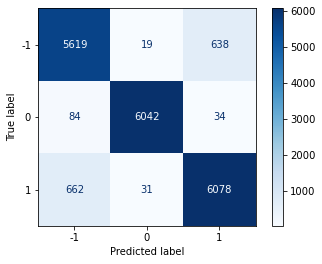

In [169]:
evaluate(output.best_estimator_, X_train_tfidf_vec_df, y_train, X_val_tfidf_vec_df, y_val)

## Linear regression with PCA

In [7]:
pipe_lr = Pipeline([
                    ('pca', PCA()), 
                    ('clr', LogisticRegression(max_iter=1000, 
                                               solver= "newton-cg",
                                               penalty = "l2", 
                                               random_state=seed)
                    )])
pipe_lr

Pipeline(steps=[('pca', PCA()),
                ('clr',
                 LogisticRegression(max_iter=1000, random_state=42,
                                    solver='newton-cg'))])

In [8]:
param_grid = {
    "pca__n_components" : [.99, .95, .9]
}

In [9]:
grid = GridSearchCV(pipe_lr, param_grid, return_train_score=True, cv = 3)

In [10]:
output = grid.fit(X_train_tfidf_vec_df, y_train)

Accuracy Score:
Train - 0.936879555709823
Test - 0.9225282449107096
  
Classification Report:
              precision    recall  f1-score   support

          -1       0.88      0.89      0.89      6276
           0       0.99      0.98      0.99      6160
           1       0.90      0.90      0.90      6771

    accuracy                           0.92     19207
   macro avg       0.92      0.92      0.92     19207
weighted avg       0.92      0.92      0.92     19207

Confusion matrix for test data


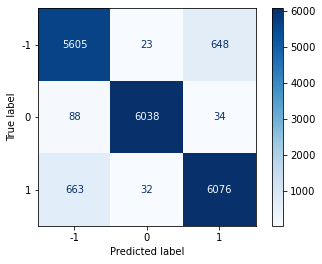

In [13]:
evaluate(output.best_estimator_, X_train_tfidf_vec_df, y_train, X_val_tfidf_vec_df, y_val)

## Naive Bayes

In [14]:
nb_tuned = Pipeline(steps=[
    ('clf', MultinomialNB()),
])
nb_tuned

Pipeline(steps=[('clf', MultinomialNB())])

In [15]:
param_grid = {
    'clf__alpha': [.1, 1e-2, 3e-3],
}

In [16]:
grid = GridSearchCV(nb_tuned, param_grid, return_train_score=True)

In [17]:
output = grid.fit(X_train_tfidf_vec_df, y_train)

In [19]:
output.best_estimator_

Pipeline(steps=[('clf', MultinomialNB(alpha=0.003))])

Accuracy Score:
Train - 0.8001388406803194
Test - 0.8038735877544645
  
Classification Report:
              precision    recall  f1-score   support

          -1       0.76      0.72      0.74      6276
           0       0.93      0.88      0.91      6160
           1       0.74      0.82      0.78      6771

    accuracy                           0.80     19207
   macro avg       0.81      0.80      0.81     19207
weighted avg       0.81      0.80      0.80     19207

Confusion matrix for test data


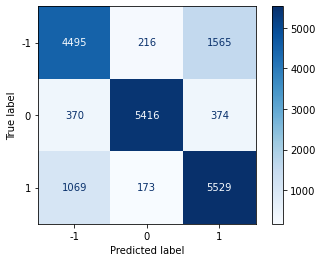

In [18]:
evaluate(output.best_estimator_, X_train_tfidf_vec_df, y_train, X_val_tfidf_vec_df, y_val)

## Decision Trees

In [1]:
dt_tuned = Pipeline(steps=[
    ('clf', DecisionTreeClassifier()),
])
dt_tuned

NameError: name 'Pipeline' is not defined

In [21]:
param_grid = {
    'clf__max_depth': [5, 15, 25],
    'clf__min_samples_leaf': [5,7,10],
    'clf__min_samples_split': [5,7,10],
}

In [22]:
grid = GridSearchCV(dt_tuned, param_grid, return_train_score=True)


In [23]:
output = grid.fit(X_train_tfidf_vec_df, y_train)

In [47]:
output.best_estimator_

Pipeline(steps=[('clf',
                 DecisionTreeClassifier(max_depth=25, min_samples_leaf=10,
                                        min_samples_split=5))])

Accuracy Score:
Train - 0.9112113849357862
Test - 0.8570312906752746
  
Classification Report:
              precision    recall  f1-score   support

          -1       0.76      0.84      0.80      6276
           0       0.99      0.98      0.99      6160
           1       0.83      0.76      0.80      6771

    accuracy                           0.86     19207
   macro avg       0.86      0.86      0.86     19207
weighted avg       0.86      0.86      0.86     19207

Confusion matrix for test data


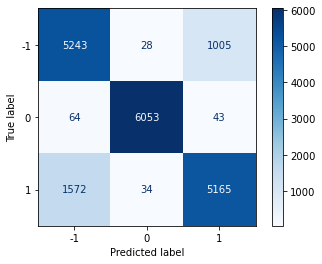

In [24]:
evaluate(output.best_estimator_, X_train_tfidf_vec_df, y_train, X_val_tfidf_vec_df, y_val)

## Support Vector Machine

In [ ]:
svm_tuned = Pipeline(steps=[
    ('clf', RandomForestClassifier()),
])
svm_tuned

In [ ]:
param_grid = {
    "clf__loss" : ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "clf__alpha" : [0.0001, 0.001, 0.01, 0.1],
    "clf__penalty" : ["l2", "l1", "elasticnet", "none"],
}

In [ ]:
grid = GridSearchCV(svm_tuned, param_grid, return_train_score=True)

In [ ]:
output = grid.fit(X_train_tfidf_vec_df, y_train)

In [ ]:
output.best_estimator_

In [ ]:
evaluate(output.best_estimator_, X_train_tfidf_vec_df, y_train, X_val_tfidf_vec_df, y_val)

## Neural Network

In [7]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [8]:
# Find our longest review - will need for padding later
max_length = max([len(s.split()) for s in X_train["processed_content"]])
max_length

6714

In [9]:
tokenizer = keras.preprocessing.text.Tokenizer()

tokenizer.fit_on_texts(X_train["processed_content"])

X_train_token = tokenizer.texts_to_sequences(X_train["processed_content"])
X_val_token = tokenizer.texts_to_sequences(X_val["processed_content"])

In [10]:
list(tokenizer.word_index.items())[:10]

[('trump', 1),
 ('said', 2),
 ('would', 3),
 ('people', 4),
 ('one', 5),
 ('state', 6),
 ('year', 7),
 ('new', 8),
 ('president', 9),
 ('time', 10)]

In [11]:
# Same example, after processing
print(X_train_token[0])

[162, 2124, 668, 644, 309, 1067, 8382, 4961, 8264, 3989, 4776, 1298, 4157, 10, 1568, 2961, 204, 7882, 202, 57, 394, 2095, 1158, 2566, 407, 1117, 436, 1224, 8382, 2, 40, 127, 539, 543, 5931, 812, 736, 708, 349, 37153, 1298, 63, 95, 1481, 586, 2013, 806, 589, 681, 401, 149, 63, 95, 396, 149, 423, 3305, 396, 149, 63, 289, 396, 29, 10, 1568, 2961, 204, 7882, 202, 57, 394, 2095, 1158, 2566, 407, 1117, 436, 1224, 98, 2369, 9, 245, 192, 349, 436, 1224, 1021, 4576, 2624, 63, 95, 681, 6383, 3647, 436, 1224, 156, 262, 25, 26, 8657, 9544, 681, 401, 143, 10826, 1376, 2556, 133, 33, 25, 1298, 8957, 407, 1224, 20, 436, 297, 3821, 5953, 94]


In [12]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

157205


In [13]:
# Now, let's pad so each review is the same length as our longest review
# Basically, adding zeros at the end

X_train_processed = keras.preprocessing.sequence.pad_sequences(
    X_train_token, maxlen=max_length, padding='post')
X_val_processed = keras.preprocessing.sequence.pad_sequences(
    X_val_token, maxlen=max_length, padding='post')

In [14]:
X_train_processed

array([[  162,  2124,   668, ...,     0,     0,     0],
       [  218,   101,    76, ...,     0,     0,     0],
       [ 1088,  2898,   764, ...,     0,     0,     0],
       ...,
       [  310,  1069,  3545, ...,     0,     0,     0],
       [  327,    95,    56, ...,     0,     0,     0],
       [  112,    51, 17444, ...,     0,     0,     0]])

In [15]:
from keras.utils import to_categorical
#one-hot encode target column
y_train2 = to_categorical(y_train)
y_val2 = to_categorical(y_val)

#vcheck that target column has been converted
y_val2[0:10]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [16]:
def create_embedding_matrix(glove_filepath, word_index, embedding_dim):
    '''
    Grabs the embeddings just for the words in our vocabulary
    
    Inputs:
    glove_filepath - string, location of the glove text file to use
    word_index - word_index attribute from the keras tokenizer
    embedding_dim - int, number of dimensions to embed, a hyperparameter
    
    Output:
    embedding_matrix - numpy array of embeddings
    '''
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(glove_filepath, encoding="UTF-8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [17]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('../data/glove.6B.50d.txt',
                                           tokenizer.word_index, 
                                           embedding_dim)

In [18]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.45769   ,  0.85191   ,  0.31097999, ..., -0.74225998,
         0.77052999,  0.26394001],
       [ 0.38973001, -0.2121    ,  0.51836997, ...,  0.86119002,
         0.1415    ,  1.20179999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.60434002, -0.97134   , -0.10733   , ..., -0.23074999,
        -0.55489999,  0.49355999]])

In [19]:
# Time to model!
model = keras.models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=False)) # Note - not retraining the embedding layer
model.add(layers.Flatten()) # flattening these layers down before connecting to dense layer
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 6714, 50)          7860250   
_________________________________________________________________
flatten (Flatten)            (None, 335700)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1007103   
Total params: 8,867,353
Trainable params: 1,007,103
Non-trainable params: 7,860,250
_________________________________________________________________


In [20]:
history = model.fit(X_train_processed, y_train2,
                    epochs=10,
                    batch_size=100,
                    validation_data=(X_val_processed, y_val2))

Epoch 1/10
577/577 [==============================] - 67s 116ms/step - loss: 1.0778 - accuracy: 0.6294 - val_loss: 1.2848 - val_accuracy: 0.6290
Epoch 2/10
577/577 [==============================] - 66s 115ms/step - loss: 0.6754 - accuracy: 0.7523 - val_loss: 1.3621 - val_accuracy: 0.6406
Epoch 3/10
577/577 [==============================] - 66s 114ms/step - loss: 0.5488 - accuracy: 0.7936 - val_loss: 1.3754 - val_accuracy: 0.6389
Epoch 4/10
577/577 [==============================] - 65s 113ms/step - loss: 0.4850 - accuracy: 0.8147 - val_loss: 1.5360 - val_accuracy: 0.6363
Epoch 5/10
577/577 [==============================] - 75s 130ms/step - loss: 0.4580 - accuracy: 0.8236 - val_loss: 1.7149 - val_accuracy: 0.6263
Epoch 6/10
577/577 [==============================] - 75s 130ms/step - loss: 0.4244 - accuracy: 0.8392 - val_loss: 1.8377 - val_accuracy: 0.6364
Epoch 7/10
577/577 [==============================] - 67s 116ms/step - loss: 0.4023 - accuracy: 0.8489 - val_loss: 2.0977 - val_ac

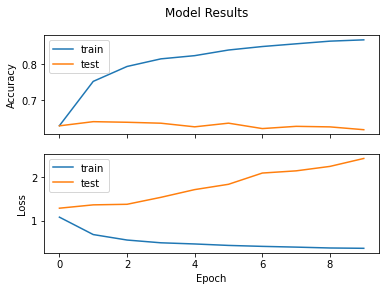

In [21]:
visualize_training_results(history)

In [22]:
model = keras.models.Sequential(name="tuned")
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=True)) 
model.add(layers.Flatten()) # flattening these layers down before connecting to dense layer
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "tuned"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 6714, 50)          7860250   
_________________________________________________________________
flatten_1 (Flatten)          (None, 335700)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1007103   
Total params: 8,867,353
Trainable params: 8,867,353
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train_processed, y_train2,
                    epochs=10,
                    batch_size=100,
                    validation_data=(X_val_processed, y_val2))

Epoch 1/10
577/577 [==============================] - 146s 253ms/step - loss: 0.9459 - accuracy: 0.6769 - val_loss: 0.8233 - val_accuracy: 0.7433
Epoch 2/10
577/577 [==============================] - 164s 284ms/step - loss: 0.3474 - accuracy: 0.8708 - val_loss: 0.7702 - val_accuracy: 0.7838
Epoch 3/10
577/577 [==============================] - 146s 253ms/step - loss: 0.1626 - accuracy: 0.9435 - val_loss: 0.7749 - val_accuracy: 0.8014
Epoch 4/10
577/577 [==============================] - 154s 267ms/step - loss: 0.0739 - accuracy: 0.9791 - val_loss: 0.8002 - val_accuracy: 0.8143
Epoch 5/10
577/577 [==============================] - 155s 269ms/step - loss: 0.0349 - accuracy: 0.9933 - val_loss: 0.8139 - val_accuracy: 0.8198
Epoch 6/10
577/577 [==============================] - 144s 250ms/step - loss: 0.0188 - accuracy: 0.9974 - val_loss: 0.7777 - val_accuracy: 0.8264
Epoch 7/10
577/577 [==============================] - 154s 266ms/step - loss: 0.0129 - accuracy: 0.9986 - val_loss: 0.8054 -

In [ ]:
visualize_training_results(history)

In [24]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [29]:
model = keras.models.Sequential(name="tuned")
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=False)) 
model.add(Conv1D(filters=25, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(layers.Flatten()) # flattening these layers down before connecting to dense layer
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "tuned"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 6714, 50)          7860250   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6710, 25)          6275      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3355, 25)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 83875)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 251628    
Total params: 8,118,153
Trainable params: 257,903
Non-trainable params: 7,860,250
_________________________________________________________________


In [ ]:
history = model.fit(X_train_processed, y_train2,
                    epochs=10,
                    batch_size=100,
                    validation_data=(X_val_processed, y_val2))

Epoch 1/10
577/577 [==============================] - 478s 829ms/step - loss: 0.7387 - accuracy: 0.6878 - val_loss: 0.6167 - val_accuracy: 0.7508
Epoch 2/10
577/577 [==============================] - 525s 909ms/step - loss: 0.5192 - accuracy: 0.7952 - val_loss: 0.5643 - val_accuracy: 0.7794
Epoch 3/10
577/577 [==============================] - 554s 961ms/step - loss: 0.4237 - accuracy: 0.8349 - val_loss: 0.5064 - val_accuracy: 0.8043
Epoch 4/10
577/577 [==============================] - 534s 926ms/step - loss: 0.3616 - accuracy: 0.8603 - val_loss: 0.5346 - val_accuracy: 0.7994
Epoch 5/10
  3/577 [..............................] - ETA: 5:36 - loss: 0.2816 - accuracy: 0.8800